In [1]:
# using DBSCAN this time -- left turns
from sklearn.cluster import DBSCAN
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from sklearn.datasets import make_blobs



In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
1,0,android_turns.csv,5.0,11.281634,2.737719,0.008573,1,19.387754,9.529365,10.491248,1.173136,11.777087,32.709633,9.324203
2,0,android_turns.csv,5.0,11.028114,3.967555,0.009012,1,16.836735,8.478003,14.696693,2.366215,22.094933,88.539480,3.087557
3,0,android_turns.csv,4.0,19.864027,5.356430,0.025984,1,20.663265,22.033857,18.588970,2.522688,16.592813,89.536600,12.669695
4,0,android_turns.csv,5.0,16.620464,5.078434,0.019170,1,19.387754,19.640330,18.141582,2.252747,18.612541,95.261020,10.121602


In [3]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_left = df_v3[(df_v3['eventType'] == 4)]
sub_df_left = sub_df_left.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sub_df_left)   # or your features df


In [5]:
min_samples = 2 * 8                     # ≈ 2 × num_features
eps = 0.5                             # from elbow plot
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
labels = db.fit_predict(X_scaled)


In [6]:
sub_df_left['dbscan_label'] = labels



In [7]:
unique, counts = np.unique(labels, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))


Cluster counts: {np.int64(-1): np.int64(3556)}


In [8]:
valid_mask = labels != -1
if len(np.unique(labels[valid_mask])) > 1:
    sil = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
    print(f"Silhouette score (excluding noise): {sil:.3f}")
else:
    print("Not enough clusters to compute silhouette score.")

Not enough clusters to compute silhouette score.


/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_8208/598517656.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


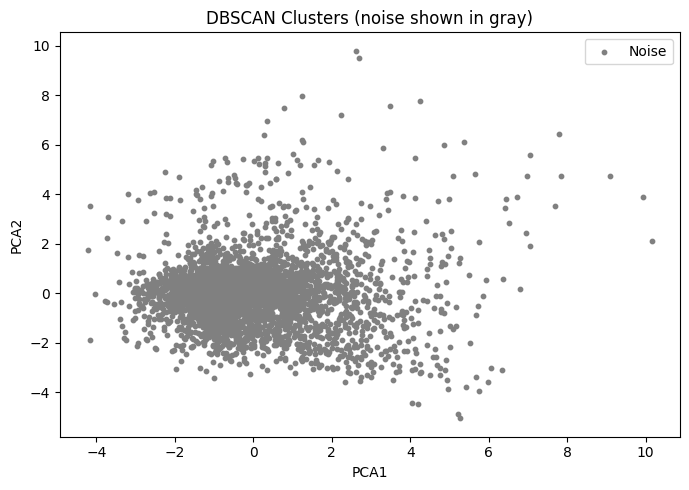

In [9]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X_scaled)
reduced_df = pd.DataFrame(reduced_X, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = labels

# Plot with color per cluster
plt.figure(figsize=(7,5))
unique_labels = np.unique(labels)

for lab in unique_labels:
    mask = reduced_df['Cluster'] == lab
    color = 'gray' if lab == -1 else None
    label = 'Noise' if lab == -1 else f'Cluster {lab}'
    plt.scatter(
        reduced_df.loc[mask, 'PCA1'],
        reduced_df.loc[mask, 'PCA2'],
        s=10,
        label=label,
        color=color,
        cmap='viridis'
    )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('DBSCAN Clusters (noise shown in gray)')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
sub_df_left['clusters'] = DBSCAN(eps=0.3, min_samples=10).fit(X) # here
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

NameError: name 'X' is not defined

In [ ]:
from sklearn import metrics

print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# define colors for each cluster
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(7, 5))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # black for noise
        label_name = "Noise"
    else:
        label_name = f"Cluster {k}"

    class_member_mask = labels == k

    # Core samples (large dots)
    xy_core = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy_core[:, 0],
        xy_core[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        label=label_name
    )

    # Non-core samples (small dots)
    xy_non_core = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy_non_core[:, 0],
        xy_non_core[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
    )

plt.title(f"DBSCAN Clusters (Estimated: {len(unique_labels) - (1 if -1 in unique_labels else 0)})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Clusters", loc="best")
plt.tight_layout()
plt.show()

In [ ]:
sub_df_left.groupby('').mean(numeric_only=True).T